# Project #3: SVD Image Compression

In [1]:
import numpy as np
import math
from numpy import linalg as LA
import pandas as pd
from matplotlib.image import imread
import matplotlib.pyplot as plt
import os
from sys import getsizeof
from PIL import Image
from numpy.linalg import svd
import time

## Introduction

Images contain data. They are comprised of pixels on the screen and are a combination of red, green and blue on a scale from 0-255. Human eyes see many colors, but in fact, a combination of red, blue and green is what the computer reads so that it can produce a color image on screen. As such, images can be written as a matrix of numbers from 0-255 but in 3 dimensions. As you can imagine, an image can hold a significant amount of storage memory. Because of this, we can use dimension reduction techniques, primarily Singlar Value Decomposition SVD from Linear Algebra, to reduce the dimensionality of the image and then output an image that (from human's perspective) looks qualitatively similar while significantly reducing the storage memory from the orginal size. 

The Notebook will explore the reduction of singular values based on the user choice and output:
- a reduced dimension color image 
- an output ratio that demonstrates the reduction of storage size from the original
- a compression ratio
- an error calculated from the original matrix and the truncated matrix of compressed image

## Methodology

The primary method used in this experiment is from Liner Algebra, i.e. Singular Value Deconomosition or SVD. Every matrix NxN or MxN has an SVD.

$ 𝐴 = 𝑈 \Sigma 𝑉 T $

Compressed size: $ m * p+p+p * n = p * (1+m +n) $

Compression ratio: $ ((p * (m+n+1))/(m * n)) * 100.0 % $

Error between matrix A storing the original image and the reduced matrix $ A_p: norm(A - A_k) $

A matrix A is decomosed into two orthogonal matricies 𝑈 and 𝑉T with a diagonal matrix Σ comprised of the singular values of the A. Note the all values in the diagonal are non-negative and the entries σ1 ≥ σ2 ≥ σ3 ≥ … ≥ 0 are listed in descending order. It turns out the the weights are heavily skewed to the first elements of the matrix and this is where we can select an arbitrary number to display a significant amount of the original matrix, thus, in this instance saving significant memory for a newly compressed image. 

For this project we will:
- load the image in color 
- decompose image using numpy SVD method
- find the number n of singular values from the decomposition that we wish to describe it
- demonstrate the % of the energy of the variance explained by the singular values from 0-k
- show the image once compressed
- output the % of memory used in relation to the original memory size of k singular value reduction
- compare using human eye the reduction of image quality for k singular values
- show the Error between original matrix and the reduced matrix


## Computer Experiments/Code

First upload this color photo into the Notebook and then scale it to 12x8. We must cast it as a Numpy array so that we can perform some of the Linear Algebra methods requisite of the SVD

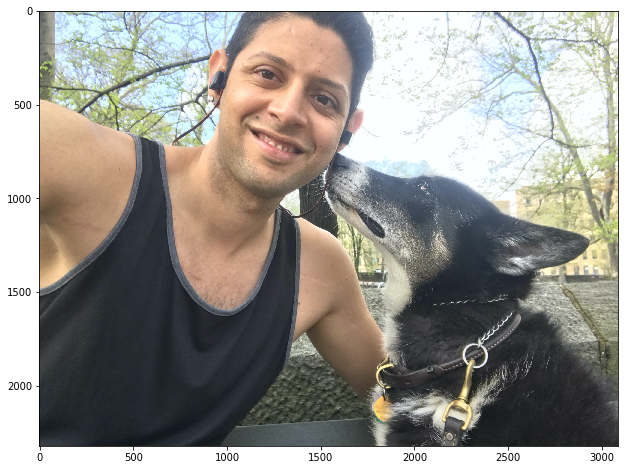

In [2]:
image2 = np.asarray(Image.open('clara.jpeg'))
plt.figure(figsize=(12,8))
plt.imshow(image2)
plt.show()

In [3]:
image2.shape

(2320, 3088, 3)

Now that we have our photo in an array format, it's values contain a color scale for the pixels. We can find the exact storage memory used for this imaage using the np.prod() method. This will be our original reference for how much storage is saved when using SVD on this image.

In [4]:
print('Color Storage Memory =', np.prod(image2.shape))

Color Storage Memory = 21492480


The following code extracts the Singular Values from our image and sums them up. First we create an array (again) using MatplotLib's imread function we call A. Then we craft a matrix A for the decomposition. Once decomposed using the np.linalg.svd() method, we have that the diagonal entries of the S matrix contains the singualr values.

In [5]:
A = imread('clara.jpeg')
X = np.mean(A, -1);
U, S, VT = np.linalg.svd(X, full_matrices=False)
S = np.diag(S) 
print('Number of Singular Values:', len(S))

Number of Singular Values: 2320


Singualar Values from SVD, like it's Mathematical cousin, the Principal Components from PCA decomposition are listed in the diagonal matrix from most heavy to least. Meaning, the vast majority of the energy of the singualar values are stored in the beginning of the diagonal. It's important to note that no matter the size of the entry, any entry even small ones take up memory. Thus, we are seeking to reduce the number of values that can describe the image. The following plot descibes cumulative sum of the percent of the energy as the singular values of the diagonal entries of S move in descenting order. The vast majority of the image, or in other examples anything described by a matrix, can be described by fewer entries, thus saving memory.

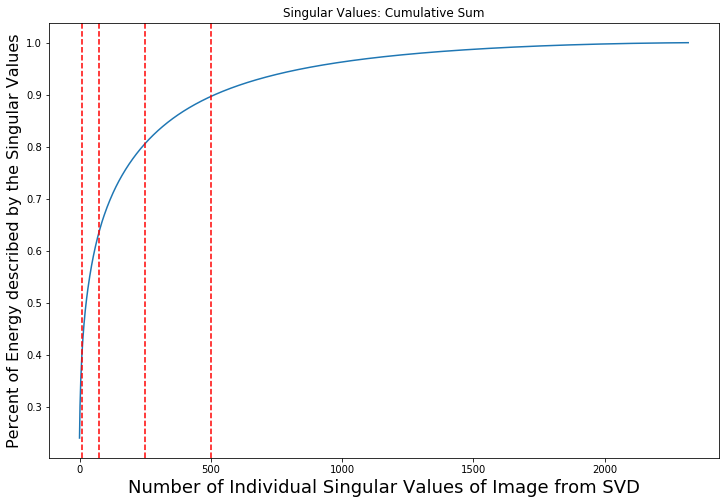

In [6]:
plt.figure(figsize=(12,8))
plt.plot(np.cumsum(np.diag(S))/np.sum(np.diag(S)))
plt.axvline(x = 500, color='red', linestyle='dashed', label='x=500 (singular values)')
plt.axvline(x = 250, color='red', linestyle='dashed', label='x=250 (singular values)')
plt.axvline(x = 75, color='red', linestyle='dashed', label='x=75 (singular values)')
plt.axvline(x = 10, color='red', linestyle='dashed', label='x=10 (singular values)')
plt.title('Singular Values: Cumulative Sum')
plt.xlabel('Number of Individual Singular Values of Image from SVD', fontsize=18)
plt.ylabel('Percent of Energy described by the Singular Values', fontsize=16)
plt.show()

It's important to note that a color image is in fact not a 2D object but 3D. So we will have to convert it into a grey image so that we can create an appropriate 2D matrix for decomposition using SVD. This code will create a matrix for the greyscale for our image, convert it into an array and then create a 2-dimensional matrix. Here we will also save the amount of memory used.   

In [7]:
img = Image.open('clara.jpeg')
imgconv = img.convert('LA')
imgmat = np.array(list(img.getdata(band = 0)), float)
imgmat.shape = (imgconv.size[1], imgconv.size[0])
imgmat = np.matrix(imgmat)
print('\nThe grayscale image as a matrix is:\n\n', imgmat)
print('\nThe dimensions of the matrix are:\n\n', np.shape(imgmat))

original_st = imgmat.shape[0]*imgmat.shape[1] 
print('\nGrayscale Storage Memory =', original_st)


The grayscale image as a matrix is:

 [[ 96.  94.  94. ... 247. 248. 247.]
 [ 95.  93.  93. ... 248. 248. 248.]
 [ 95.  95.  96. ... 249. 249. 249.]
 ...
 [ 50.  53.  55. ...  47.  49.  49.]
 [ 52.  54.  53. ...  46.  47.  47.]
 [ 55.  55.  52. ...  46.  45.  45.]]

The dimensions of the matrix are:

 (2320, 3088)

Grayscale Storage Memory = 7164160


The following function takes in an image, and outputs the image result when we use the first k singular values to describe that image. The choice of k is arbitrary and is up to user. 

In [8]:
def compress_image(img, k):      
  
    #Calling the dimensions of the image in 2D
    m = img.shape[0]
    n = img.shape[1]
    
    #Splitting the array into three 2D arrays for each color Red, Green, Blue
    r = img[:,:,0]  
    g = img[:,:,1]  
    b = img[:,:,2]      
    
    # Calculating the svd components for all three arrays
    ur,sr,vr = svd(r, full_matrices=False)
    ug,sg,vg = svd(g, full_matrices=False)
    ub,sb,vb = svd(b, full_matrices=False)
    
    #Now we select the first k singular values for each array, this is our reduction 
    #the new image will have areduced dimension ur (mxk), diag(sr) (kxk) and vr (kxn) if image is off (MxN)
    rr = np.dot(ur[:, :k], np.dot(np.diag(sr[:k]), vr[:k, :]))
    rg = np.dot(ug[:, :k], np.dot(np.diag(sg[:k]), vg[:k, :]))
    rb = np.dot(ub[:, :k], np.dot(np.diag(sb[:k]), vb[:k, :]))
    
    #Here we calculate the storage size of our reduced Matricies which we will compage to the original
    rr_st = np.shape(ur[:, :k])[0] * np.shape(ur[:, :k])[1] + np.shape(vr[:k, :])[0] * np.shape(vr[:k, :])[1]
    rg_st = np.shape(ug[:, :k])[0] * np.shape(ug[:, :k])[1] + np.shape(vg[:k, :])[0] * np.shape(vg[:k, :])[1]
    rb_st = np.shape(ub[:, :k])[0] * np.shape(ub[:, :k])[1] + np.shape(vb[:k, :])[0] * np.shape(vb[:k, :])[1]
    
    #Creating a array of zeroes; shape will be same as original Image Matrix
    rimg = np.zeros(img.shape)   
   
    #Adding matrix for the color Red, Greeen & Blue in created array. Recall all color images are 3D
    rimg[:,:,0] = rr
    rimg[:,:,1] = rg
    rimg[:,:,2] = rb
    
    # It will check if any value will be less than 0 will be converted to its absolute
    # and, if any value is greater than 255 than it will be converted to 255
    # because in image array of unit8 can only have value between 0 & 255
    for ind1, row in enumerate(rimg):
        for ind2, col in enumerate(row):
            for ind3, value in enumerate(col):
                if value < 0:
                    rimg[ind1,ind2,ind3] = abs(value)
                if value > 255:
                    rimg[ind1,ind2,ind3] = 255                   
    
    #Converting the compressed image array to uint8 type for further conversion into an image object
    compressed_image = rimg.astype(np.uint8)
    
    #Calculate the error between our images, recall even compressed images have the same dimension
    error = np.linalg.norm(img - compressed_image)
    
    #Calculate the Compression_Ratio for our reduced image
    compression_ratio = ((k*(m+n+1))/(m*n))*100
    
    #Print new storage size for each compressed image and % of memory used in comparison to our original
    #i.e. How effective was our reduction based on choice of k
    print('---------------')
    print('Original Image Storage Size: ', np.prod(image2.shape))
    print('The number of singular values used is: ',k)
    print('New Storage Size:', rr_st + rg_st + rb_st)
    print('Percent of Storage Memory:', (rr_st + rg_st + rb_st)/np.prod(img.shape))
    print('The Compression Ratio for this reduction is:',compression_ratio)
    print('Error between Original and Compressed Image is:', error)
    
    plt.figure(figsize=(12,8))
    plt.imshow(compressed_image)
    plt.show()

Again our choice of k is arbitrarty but our earlier graph of the weight of the energy of the singular values show that roughly 90% of image information is stored in the first 500 singular values. For this experiment we will choose the first 10, 75, 250, 500 entries. 

---------------
Original Image Storage Size:  21492480
The number of singular values used is:  10
New Storage Size: 162240
Percent of Storage Memory: 0.007548686796498124
The Compression Ratio for this reduction is: 0.755008263355369
Error between Original and Compressed Image is: 755962.6977973186


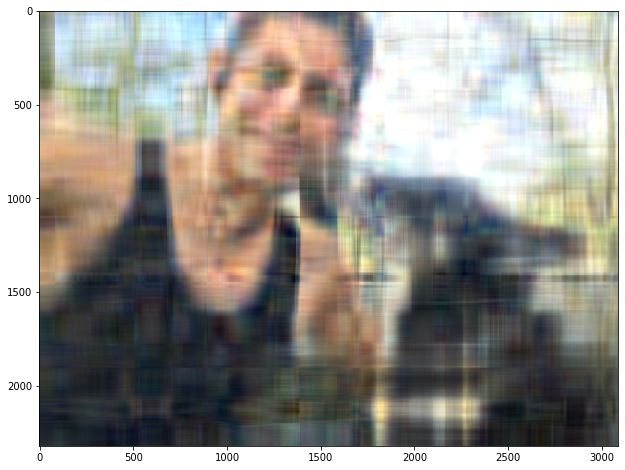

Time to compress image:  58.33062481880188  seconds

---------------
Original Image Storage Size:  21492480
The number of singular values used is:  75
New Storage Size: 1216800
Percent of Storage Memory: 0.05661515097373593
The Compression Ratio for this reduction is: 5.662561975165267
Error between Original and Compressed Image is: 746157.3702229309


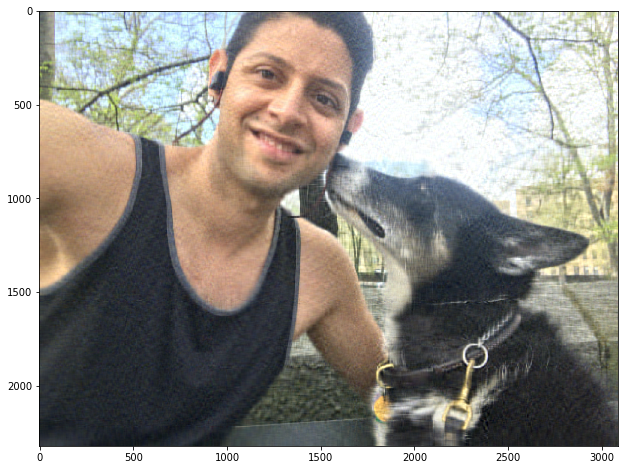

Time to compress image:  62.13130497932434  seconds

---------------
Original Image Storage Size:  21492480
The number of singular values used is:  250
New Storage Size: 4056000
Percent of Storage Memory: 0.1887171699124531
The Compression Ratio for this reduction is: 18.875206583884225
Error between Original and Compressed Image is: 695994.1702938323


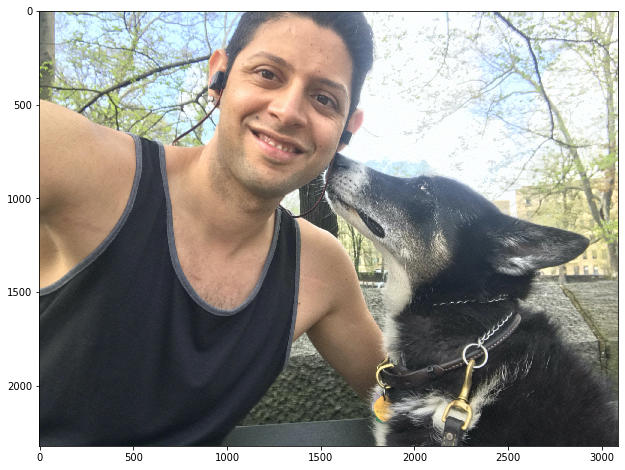

Time to compress image:  56.514240741729736  seconds

---------------
Original Image Storage Size:  21492480
The number of singular values used is:  500
New Storage Size: 8112000
Percent of Storage Memory: 0.3774343398249062
The Compression Ratio for this reduction is: 37.75041316776845
Error between Original and Compressed Image is: 599573.4248113404


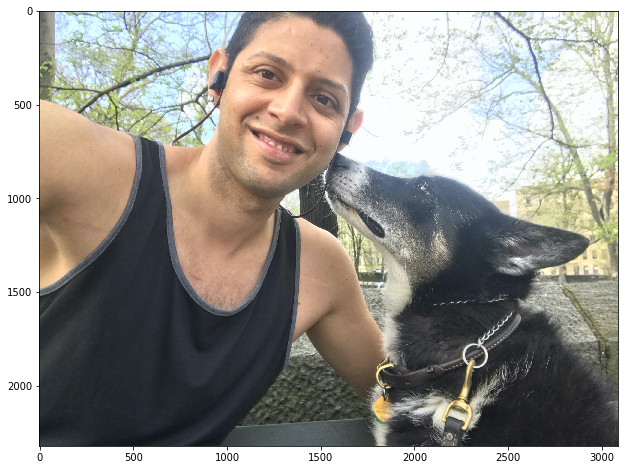

Time to compress image:  56.56796216964722  seconds



In [9]:
for x in [10,75,250,500]:
    start = time.time()
    compress_image(image2, x)
    end = time.time()
    print('Time to compress image: ' , (end - start), ' seconds')
    print('')

# IV.) Conclusion

To reduce the storage memory for a color image in Python we have made extensive use of NumPy, MatPlotLib and LinearAlg methods. To to this, first we loaded a photo taken with an iPhone 11 XR. The image is of great quality, but that also means there is a heafty storage price of 21492480 bits. Once we decomposed this image using the Singular Value Decomposition (SVD) method, from NumPy, we were able to determine there were 2320 singular values. The SVD, like PCA, lists its singualar values along the diagonal of the inner matrix in descending order. As such, we are able to graph the weight of the energy of the diagonal entries and we notice that, from the human eye, roughly 90% of the energy is stored in the first 500 singular values. As such we crafted a compression function that uses the image and our desired number of singular values as arguments, this function then outputs a reduced image and supporting statistics; new storage size, percent of storage memory, compression ratio, error between images using matrix subtraction and norm fucntion. 

For this particular image, our experiment selected 10, 75, 250 and 500 singular values. 
- 10 singular values held just over half a percent of the orginial image and very big error, one can barely see anything other than a human and possibly a dog 
- 75 singular values held just over 5.5% of the orginal storage memory, the reduction was significant and one can discern virtully all relevant details of the photo, however this photo quality is also reduced by this reduction and one can easily be sure that there is a difference. 
- 250 singular values holds just 18.8717% of the original size but is almost indistinguishable from the original 
- 500 singualr values holds 37.74% of memory of the original image but is actually indistinguishable from 250. 

### Original image vs. SVD compressed image using 500 singular values

Original: 


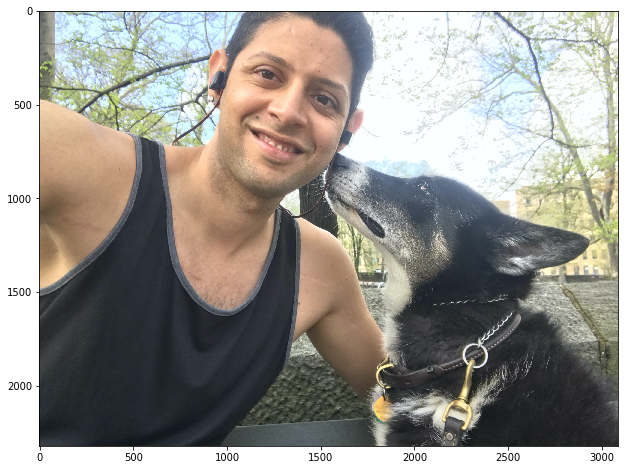

Compressed: 
---------------
Original Image Storage Size:  21492480
The number of singular values used is:  500
New Storage Size: 8112000
Percent of Storage Memory: 0.3774343398249062
The Compression Ratio for this reduction is: 37.75041316776845
Error between Original and Compressed Image is: 599573.4248113404


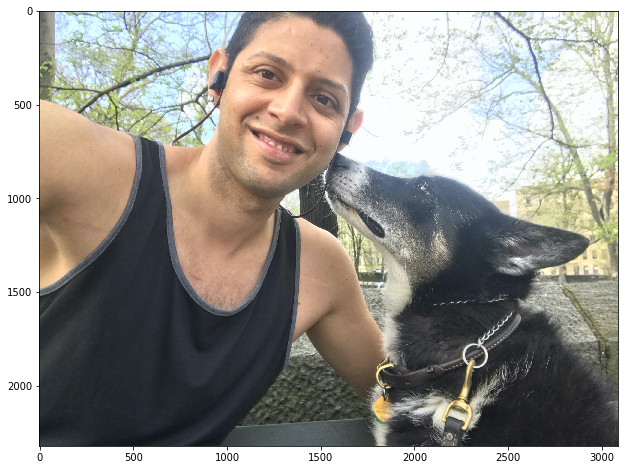

In [10]:
print('Original: ')
plt.figure(figsize=(12,8))
plt.imshow(image2)
plt.show()
print('Compressed: ')
compress_image(image2, 500)

# V.) References

Sauer, T. (2017). Numerical Analysis (3rd ed.). Upper Saddle River, NJ: Pearson.

http://timbaumann.info/svd-image-compression-demo/
    
Putalapattu, R. (2018, June 20). Jupyter, python, Image compression and svd — An interactive exploration. Medium. https://medium.com/@rameshputalapattu/jupyter-python-image-compression-and-svd-an-interactive-exploration-703c953e44f6

Steve Brunton. (2020, February 2). SVD: Image Compression [Python]. YouTube. https://www.youtube.com/watch?v=H7qMMudo3e8

matplotlib.pyplot.imread — Matplotlib 3.4.1 documentation. (2021). Https://Matplotlib.Org/. https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imread.html